# Tugas Besar 2 IF3270 Pembelajaran Mesin - CNN
Kelompok 36
1. Shazya Audrea Taufik - 13522063
2. Evelyn Yosiana - 13522083
3. Zahira Dina Amalia - 13522085

## Import Libraries and Setup

In [7]:
import os
import gdown
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.18.0
GPU Available: False


## Data Preparation

In [9]:
def download_from_gdrive(file_id, output):
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, output, quiet=False)

In [13]:
class DataPreprocessor:
    def __init__(self, max_features=10000, max_length=100):
        self.max_features = max_features
        self.max_length = max_length
        self.tokenizer = None
        self.label_encoder = LabelEncoder()

    def load_nusax_data(self):
        """Load NusaX-Sentiment dataset"""
        try:
            os.makedirs("data", exist_ok=True)
            # Download tiap file (isi file_id sesuai)
            download_from_gdrive("1l_qbRIStUngKaIjvwTahkzMzC2_U_sOi", "data/train.csv")
            download_from_gdrive("1ND6w754XzETfCCKVoJhj06C4XnuIyRU9", "data/valid.csv")
            download_from_gdrive("1Xrxv_Qg8sNFQTq0mCQAWtP1kNofkmKOs", "data/test.csv")

            # Load ke dataframe
            train_df = pd.read_csv("data/train.csv")
            val_df = pd.read_csv("data/valid.csv")
            test_df = pd.read_csv("data/test.csv")
            return train_df, val_df, test_df

            # Label encoding
            train_df['label'] = train_df['label'].astype(str)
            val_df['label'] = val_df['label'].astype(str)
            test_df['label'] = test_df['label'].astype(str)

            self.label_encoder.fit(train_df['label'])

            y_train = self.label_encoder.transform(train_df['label'])
            y_val = self.label_encoder.transform(val_df['label'])
            y_test = self.label_encoder.transform(test_df['label'])

        except Exception as e:
            print(f"Error loading dataset: {e}")
            # Create dummy data for demonstration
            return self.create_dummy_data()

    def create_dummy_data(self):
        """Create dummy sentiment data for demonstration"""
        texts = [
            "Saya sangat senang dengan produk ini",
            "Pelayanan yang buruk sekali",
            "Biasa saja tidak istimewa",
            "Luar biasa bagus sekali",
            "Mengecewakan banget",
            "Cukup memuaskan",
            "Sangat tidak puas",
            "Recommended banget",
            "Jelek banget kualitasnya",
            "Mantap sekali"
        ] * 100  # Multiply to get more data

        labels = [2, 0, 1, 2, 0, 1, 0, 2, 0, 2] * 100  # 0: negative, 1: neutral, 2: positive

        df = pd.DataFrame({'text': texts, 'label': labels})

        # Split into train, val, test
        train_size = int(0.7 * len(df))
        val_size = int(0.15 * len(df))

        train_df = df[:train_size]
        val_df = df[train_size:train_size+val_size]
        test_df = df[train_size+val_size:]

        return train_df, val_df, test_df

    def preprocess_data(self, train_df, val_df, test_df):
        # Tokenization
        self.tokenizer = Tokenizer(num_words=self.max_features, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(train_df['text'])

        # Sequences
        X_train = self.tokenizer.texts_to_sequences(train_df['text'])
        X_val = self.tokenizer.texts_to_sequences(val_df['text'])
        X_test = self.tokenizer.texts_to_sequences(test_df['text'])

        X_train = pad_sequences(X_train, maxlen=self.max_length, padding='post')
        X_val = pad_sequences(X_val, maxlen=self.max_length, padding='post')
        X_test = pad_sequences(X_test, maxlen=self.max_length, padding='post')

        # Label encoding
        self.label_encoder.fit(train_df['label'])

        y_train = self.label_encoder.transform(train_df['label'])
        y_val = self.label_encoder.transform(val_df['label'])
        y_test = self.label_encoder.transform(test_df['label'])

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

## Model

In [14]:
class RNNModel:
    def __init__(self, vocab_size, embedding_dim=128, max_length=100, num_classes=3):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self, rnn_layers=1, rnn_units=64, bidirectional=True, dropout_rate=0.5):
        """Build RNN model with specified architecture"""
        model = keras.Sequential()

        # Embedding layer
        model.add(layers.Embedding(self.vocab_size, self.embedding_dim,
                                 input_length=self.max_length, mask_zero=True))

        # RNN layers
        for i in range(rnn_layers):
            return_sequences = (i < rnn_layers - 1)  # Only last layer doesn't return sequences

            if bidirectional:
                model.add(layers.Bidirectional(
                    layers.SimpleRNN(rnn_units, return_sequences=return_sequences, dropout=dropout_rate)
                ))
            else:
                model.add(layers.SimpleRNN(rnn_units, return_sequences=return_sequences, dropout=dropout_rate))

            # Add dropout between RNN layers
            if i < rnn_layers - 1:
                model.add(layers.Dropout(dropout_rate))

        # Dense layers
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        # Compile model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """Train the model"""
        callbacks = [
            keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
        ]

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """Evaluate model and return macro F1-score"""
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        macro_f1 = f1_score(y_test, y_pred_classes, average='macro')

        print(f"Macro F1-Score: {macro_f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_classes))

        return macro_f1, y_pred_classes

    def save_model(self, filepath):
        """Save model weights"""
        self.model.save_weights(filepath)
        print(f"Model weights saved to {filepath}")



## Model From Scratch

In [70]:
import numpy as np

class RNNFromScratch:
    def __init__(self, vocab_size, embedding_dim, rnn_units, num_classes, max_length):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.rnn_units = rnn_units
        self.num_classes = num_classes
        self.max_length = max_length
        self.cache_batches = []

        # Initialize weights
        self.weights = {}
        self.init_weights()

    def init_weights(self):
        """Initialize weights randomly"""
        # Embedding weights
        self.weights['embedding'] = np.random.randn(self.vocab_size, self.embedding_dim) * 0.1

        # RNN weights
        self.weights['Wxh'] = np.random.randn(self.embedding_dim, self.rnn_units) * 0.1
        self.weights['Whh'] = np.random.randn(self.rnn_units, self.rnn_units) * 0.1
        self.weights['bh'] = np.zeros((self.rnn_units,))

        # Dense layer weights
        self.weights['Wy'] = np.random.randn(self.rnn_units, self.num_classes) * 0.1
        self.weights['by'] = np.zeros((self.num_classes,))

    def load_keras_weights(self, keras_model):
        """Load weights from trained Keras model"""
        keras_weights = keras_model.get_weights()

        # Extract weights based on model architecture
        self.weights['embedding'] = keras_weights[0]  # Embedding layer

        # For SimpleRNN layer (adjust indices based on your model)
        if len(keras_weights) >= 4:
            self.weights['Wxh'] = keras_weights[1]  # Input-to-hidden weights
            self.weights['Whh'] = keras_weights[2]  # Hidden-to-hidden weights
            self.weights['bh'] = keras_weights[3]   # Hidden bias

        # Dense layer weights (last layers)
        if len(keras_weights) >= 6:
            self.weights['Wy'] = keras_weights[-2]  # Output weights
            self.weights['by'] = keras_weights[-1]  # Output bias

    def embedding_forward(self, x):
        """Forward pass through embedding layer"""
        # x shape: (batch_size, seq_length)
        # output shape: (batch_size, seq_length, embedding_dim)
        return self.weights['embedding'][x]

    def rnn_forward(self, x):
        """Forward pass through RNN layer"""
        batch_size, seq_length, _ = x.shape
        h = np.zeros((batch_size, self.rnn_units))
        h_cache = []

        # Process each time step
        for t in range(seq_length):
            h = np.tanh(np.dot(x[:, t, :], self.weights['Wxh']) + np.dot(h, self.weights['Whh']) + self.weights['bh'])
            h_cache.append(h.copy())

        return h, h_cache

    def dense_forward(self, x):
        """Forward pass through dense layer"""
        return np.dot(x, self.weights['Wy']) + self.weights['by']

    def softmax(self, x):
        """Softmax activation"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, x, batch_size=32):
        """Complete forward pass with batch processing"""
        if len(x.shape) == 1:
            x = x.reshape(1, -1)

        self.cache_batches = []
        num_samples = x.shape[0]
        all_predictions = []

        # Process in batches
        for i in range(0, num_samples, batch_size):
            batch_end = min(i + batch_size, num_samples)
            batch_x = x[i:batch_end]

            # Forward pass for this batch
            embeddings = self.embedding_forward(batch_x)
            rnn_output, h_cache = self.rnn_forward(embeddings)
            dense_output = self.dense_forward(rnn_output)
            predictions = self.softmax(dense_output)

            self.cache_batches.append({
                'x': batch_x,
                'embeddings': embeddings,
                'h_cache': h_cache,
                'rnn_output': rnn_output,
                'predictions': predictions,
                'batch_start': i,
                'batch_end': batch_end
            })
            all_predictions.append(predictions)

        return np.vstack(all_predictions)

    def backward_embedding(self, dout, x):
        """Backward pass through embedding layer"""
        batch_size, seq_length, embedding_dim = dout.shape
        demb = np.zeros_like(self.weights['embedding'])

        for i in range(batch_size):
            for j in range(seq_length):
                if x[i, j] != 0:  # Skip padding tokens
                    demb[x[i, j]] += dout[i, j]

        return demb

    def backward_rnn(self, dout, x, h_cache):
        """Backward pass through RNN layer"""
        batch_size, seq_length, embedding_dim = x.shape

        # Initialize gradients
        dWxh = np.zeros_like(self.weights['Wxh'])
        dWhh = np.zeros_like(self.weights['Whh'])
        dbh = np.zeros_like(self.weights['bh'])
        dx = np.zeros_like(x)

        # Backward through time
        dh_next = dout.copy()

        for t in reversed(range(seq_length)):
            # Get cached values from forward pass
            h_t = h_cache[t]
            h_prev = h_cache[t - 1] if t > 0 else np.zeros_like(h_t)

            # Gradient through tanh
            dtanh = dh_next * (1 - h_t ** 2)

            # Gradients
            dbh += np.sum(dtanh, axis=0)
            dWxh += np.dot(x[:, t, :].T, dtanh)
            dWhh += np.dot(h_prev.T, dtanh)

            # Gradients for inputs
            dx[:, t, :] = np.dot(dtanh, self.weights['Wxh'].T)
            dh_next = np.dot(dtanh, self.weights['Whh'].T)

        return dx, dWxh, dWhh, dbh

    def backward_dense(self, dout, x):
        """Backward pass through dense layer"""
        dWy = np.dot(x.T, dout)
        dby = np.sum(dout, axis=0)
        dx = np.dot(dout, self.weights['Wy'].T)

        return dx, dWy, dby

    def backward(self, x, y_true, y_pred, learning_rate=0.001):
        """Complete backward pass"""
        y_true = np.asarray(y_true).astype(int)  # Ensure integer labels

        # Initialize gradient accumulators
        total_dWy = np.zeros_like(self.weights['Wy'])
        total_dby = np.zeros_like(self.weights['by'])
        total_dWxh = np.zeros_like(self.weights['Wxh'])
        total_dWhh = np.zeros_like(self.weights['Whh'])
        total_dbh = np.zeros_like(self.weights['bh'])
        total_dembed = np.zeros_like(self.weights['embedding'])

        total_samples = 0

        # Process each cached batch
        for batch_info in self.cache_batches:
            batch_x = batch_info['x']
            embeddings = batch_info['embeddings']
            h_cache = batch_info['h_cache']
            rnn_output = batch_info['rnn_output']
            batch_start = batch_info['batch_start']
            batch_end = batch_info['batch_end']

            # Get the corresponding predictions and true labels for this batch
            batch_pred = y_pred[batch_start:batch_end]
            batch_true = y_true[batch_start:batch_end]  # Fixed: use slice of y_true

            batch_size = batch_x.shape[0]
            total_samples += batch_size

            # Validate label range
            assert np.all((batch_true >= 0) & (batch_true < self.num_classes)), \
                f"Label out of range: {np.unique(batch_true)} (max allowed = {self.num_classes - 1})"

            # Build correct one-hot encoding - Fixed the indexing issue
            y_true_onehot = np.zeros((batch_size, self.num_classes))
            y_true_onehot[np.arange(batch_size), batch_true] = 1

            # Compute gradients for this batch
            dout = (batch_pred - y_true_onehot) / batch_size  # Added normalization
            ddense, dWy, dby = self.backward_dense(dout, rnn_output)
            dx_rnn, dWxh, dWhh, dbh = self.backward_rnn(ddense, embeddings, h_cache)
            dembed = self.backward_embedding(dx_rnn, batch_x)

            # Accumulate gradients
            total_dWy += dWy
            total_dby += dby
            total_dWxh += dWxh
            total_dWhh += dWhh
            total_dbh += dbh
            total_dembed += dembed

        # Average gradients across all samples (already normalized per batch above)
        num_batches = len(self.cache_batches)
        total_dWy /= num_batches
        total_dby /= num_batches
        total_dWxh /= num_batches
        total_dWhh /= num_batches
        total_dbh /= num_batches
        total_dembed /= num_batches

        # Apply gradient clipping (optional but recommended for BPTT stability)
        clip_value = 5.0
        np.clip(total_dWy, -clip_value, clip_value, out=total_dWy)
        np.clip(total_dby, -clip_value, clip_value, out=total_dby)
        np.clip(total_dWxh, -clip_value, clip_value, out=total_dWxh)
        np.clip(total_dWhh, -clip_value, clip_value, out=total_dWhh)
        np.clip(total_dbh, -clip_value, clip_value, out=total_dbh)
        np.clip(total_dembed, -clip_value, clip_value, out=total_dembed)

        # Apply gradients
        self.weights['Wy'] -= learning_rate * total_dWy
        self.weights['by'] -= learning_rate * total_dby
        self.weights['Wxh'] -= learning_rate * total_dWxh
        self.weights['Whh'] -= learning_rate * total_dWhh
        self.weights['bh'] -= learning_rate * total_dbh
        self.weights['embedding'] -= learning_rate * total_dembed

        print(f"Backward propagation applied to {total_samples} samples across {len(self.cache_batches)} batches.")
        print("Backward propagation with full BPTT applied.")

    def train_step(self, x, y_true, learning_rate=0.001):
        """Single training step: forward + backward"""
        # Forward pass
        y_pred = self.forward(x)

        # Backward pass
        self.backward(x, y_true, y_pred, learning_rate)

        return y_pred

In [16]:
def plot_training_history(histories, labels, title):
    """Plot training and validation loss/accuracy"""
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} - Training Loss')
        plt.plot(history.history['val_loss'], label=f'{label} - Validation Loss', linestyle='--')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} - Training Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{label} - Validation Accuracy', linestyle='--')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## **Testing Variations**

### Proses Data

In [30]:
print("=== Simple RNN for Text Classification ===\n")

# 1. Data Preprocessing
print("1. Loading and preprocessing data...")
preprocessor = DataPreprocessor(max_features=10000, max_length=100)
train_df, val_df, test_df = preprocessor.load_nusax_data()

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

(X_train, y_train), (X_val, y_val), (X_test, y_test) = preprocessor.preprocess_data(train_df, val_df, test_df)

print(f"Vocabulary size: {len(preprocessor.tokenizer.word_index) + 1}")
print(f"Number of classes: {len(np.unique(y_train))}")


=== Simple RNN for Text Classification ===

1. Loading and preprocessing data...


Downloading...
From: https://drive.google.com/uc?id=1l_qbRIStUngKaIjvwTahkzMzC2_U_sOi
To: /content/data/train.csv
100%|██████████| 84.1k/84.1k [00:00<00:00, 57.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ND6w754XzETfCCKVoJhj06C4XnuIyRU9
To: /content/data/valid.csv
100%|██████████| 67.6k/67.6k [00:00<00:00, 62.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xrxv_Qg8sNFQTq0mCQAWtP1kNofkmKOs
To: /content/data/test.csv
100%|██████████| 16.6k/16.6k [00:00<00:00, 23.3MB/s]

Train samples: 500
Validation samples: 400
Test samples: 100
Vocabulary size: 2796
Number of classes: 3


### Percobaan 1 : Pengaruh Jumlah Layer Layer RNN


2. Experimenting with different numbers of RNN layers

Training model with 1 RNN layer(s)
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.2883 - loss: 1.1454 - val_accuracy: 0.4350 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.4553 - loss: 1.0142 - val_accuracy: 0.4425 - val_loss: 1.0349 - learning_rate: 0.0010
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.5373 - loss: 0.9321 - val_accuracy: 0.5100 - val_loss: 1.0011 - learning_rate: 0.0010
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6955 - loss: 0.8071 - val_accuracy: 0.5650 - val_loss: 0.9783 - learning_rate: 0.0010
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.7514 - loss: 0.7097 - val_accuracy: 0.5450 - val_loss: 0.9455 - learning_rate: 0.0010
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.8920 - loss: 0.4543 - val_accuracy: 0.6375 - val_loss: 0.8512 - learning_rate: 0.00

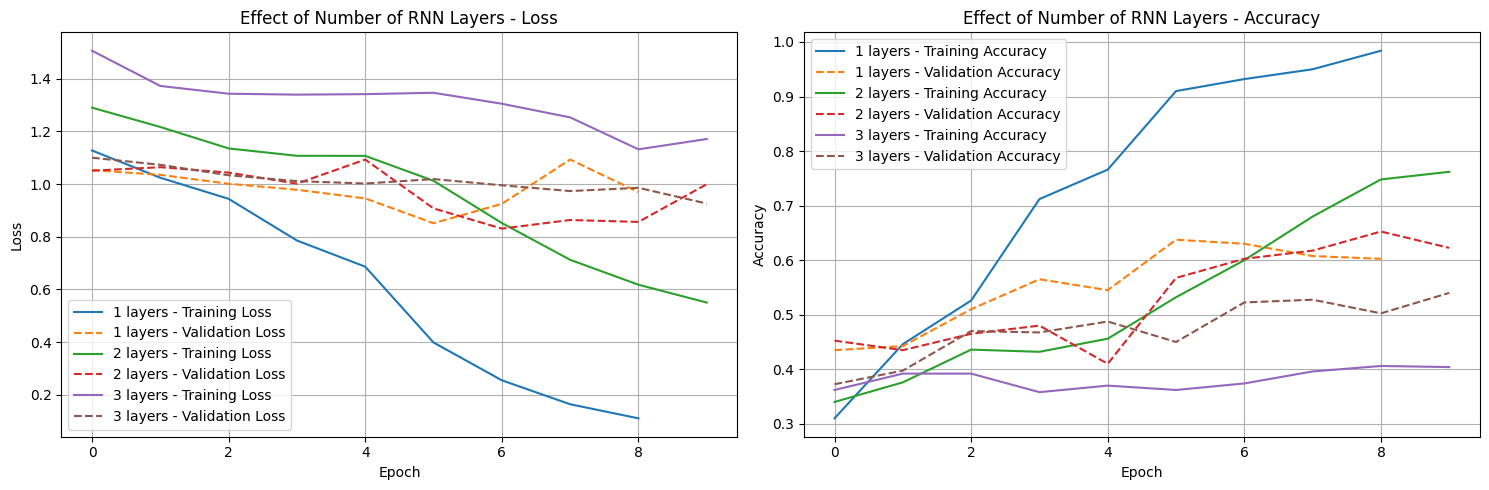

In [31]:
# Percobaan 1 : Pengaruh Jumlah Layer Layer RNN
print("\n2. Experimenting with different numbers of RNN layers")
layer_variations = [1, 2, 3]
layer_histories = []
layer_f1_scores = []

for num_layers in layer_variations:
    print(f"\nTraining model with {num_layers} RNN layer(s)")

    model = RNNModel(
        vocab_size=len(preprocessor.tokenizer.word_index) + 1,
        embedding_dim=128,
        max_length=100,
        num_classes=3
    )

    model.build_model(rnn_layers=num_layers, rnn_units=64, bidirectional=True)
    history = model.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=32)
    f1_val, _ = model.evaluate(X_test, y_test)

    layer_histories.append(history)
    layer_f1_scores.append(f1_val)

    # Save model
    model.save_model(f'rnn_model_{num_layers}_layers.weights.h5')

# Plot results
plot_training_history(layer_histories, [f'{l} layers' for l in layer_variations],
                      'Effect of Number of RNN Layers')

In [32]:
print("\nKesimpulan Percobaan Jumlah Layer RNN:")
for num_layers, f1 in zip(layer_variations, layer_f1_scores):
    print(f"{num_layers} layer(s): F1-Score = {f1:.4f}")


Kesimpulan Percobaan Jumlah Layer RNN:
1 layer(s): F1-Score = 0.5843
2 layer(s): F1-Score = 0.5435
3 layer(s): F1-Score = 0.4987


### Percobaan 2: Pengaruh Banyak Cell RNN per Layer


3. Experimenting with different numbers of RNN units...

Training model with 32 RNN units...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - accuracy: 0.3723 - loss: 1.2082 - val_accuracy: 0.3625 - val_loss: 1.0914 - learning_rate: 0.0010
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.3762 - loss: 1.1524 - val_accuracy: 0.3700 - val_loss: 1.0822 - learning_rate: 0.0010
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.3719 - loss: 1.1793 - val_accuracy: 0.4000 - val_loss: 1.0696 - learning_rate: 0.0010
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.3891 - loss: 1.1482 - val_accuracy: 0.3900 - val_loss: 1.0692 - learning_rate: 0.0010
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.4084 - loss: 1.0847 - val_accuracy: 0.4175 - val_loss: 1.0636 - learning_rate: 0.0010
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.3988 - loss: 1.0855 - val_accuracy: 0.3975 - val_loss: 1.0693 - learning_rate: 

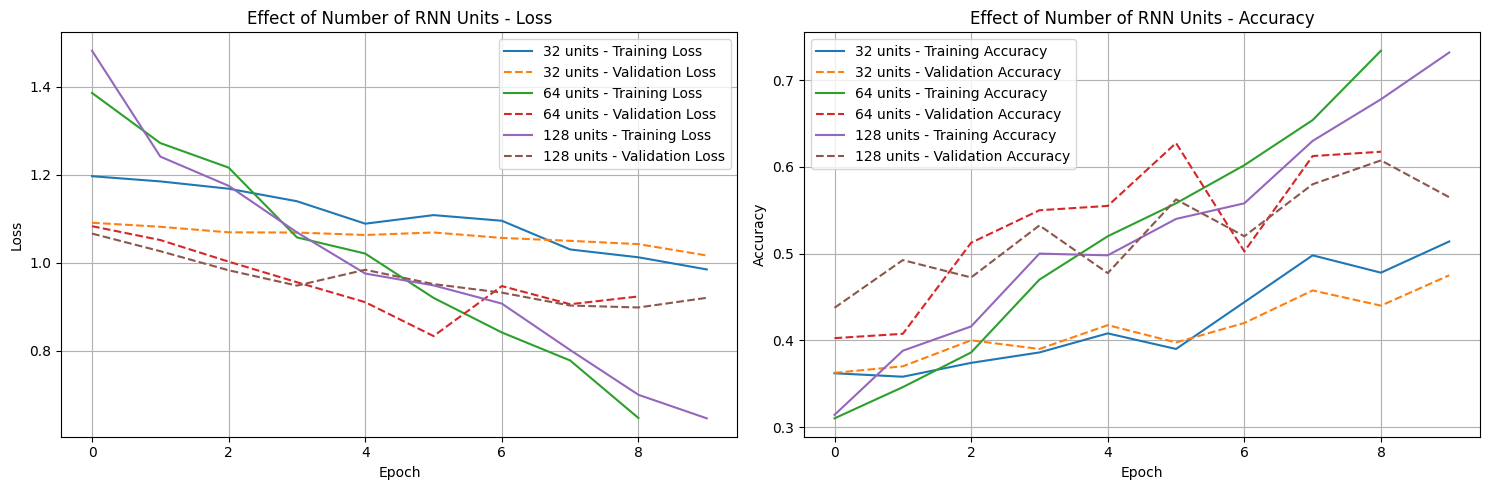

In [33]:
print("\n3. Experimenting with different numbers of RNN units...")
unit_variations = [32, 64, 128]
unit_histories = []
unit_f1_scores = []

for num_units in unit_variations:
    print(f"\nTraining model with {num_units} RNN units...")

    model = RNNModel(
        vocab_size=len(preprocessor.tokenizer.word_index) + 1,
        embedding_dim=128,
        max_length=100,
        num_classes=3
    )

    model.build_model(rnn_layers=2, rnn_units=num_units, bidirectional=True)
    history = model.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=32)
    f1_val, _ = model.evaluate(X_test, y_test)

    unit_histories.append(history)
    unit_f1_scores.append(f1_val)

    # Save model
    model.save_model(f'rnn_model_{num_units}_units.weights.h5')

# Plot results
plot_training_history(unit_histories, [f'{u} units' for u in unit_variations],
                      'Effect of Number of RNN Units')

In [34]:
print("\nKesimpulan Percobaan Jumlah RNN Units:")
for num_units, f1 in zip(unit_variations, unit_f1_scores):
    print(f"{num_units} units: F1-Score = {f1:.4f}")


Kesimpulan Percobaan Jumlah RNN Units:
32 units: F1-Score = 0.6194
64 units: F1-Score = 0.5602
128 units: F1-Score = 0.5073


### Percobaan 3: Pengaruh Jenis Layer RNN berdasarkan Arah


4. Experimenting with bidirectional vs unidirectional RNN...

Training Bidirectional RNN model...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.3690 - loss: 1.2991 - val_accuracy: 0.3600 - val_loss: 1.0872 - learning_rate: 0.0010
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.3682 - loss: 1.2174 - val_accuracy: 0.4200 - val_loss: 1.0315 - learning_rate: 0.0010
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.4432 - loss: 1.1683 - val_accuracy: 0.4475 - val_loss: 1.0396 - learning_rate: 0.0010
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.4423 - loss: 1.0826 - val_accuracy: 0.5250 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.4728 - loss: 1.0506 - val_accuracy: 0.5375 - val_loss: 0.9213 - learning_rate: 0.0010
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.5253 - loss: 0.9482 - val_accuracy: 0.5550 - val_loss: 0.9085 - learning_r

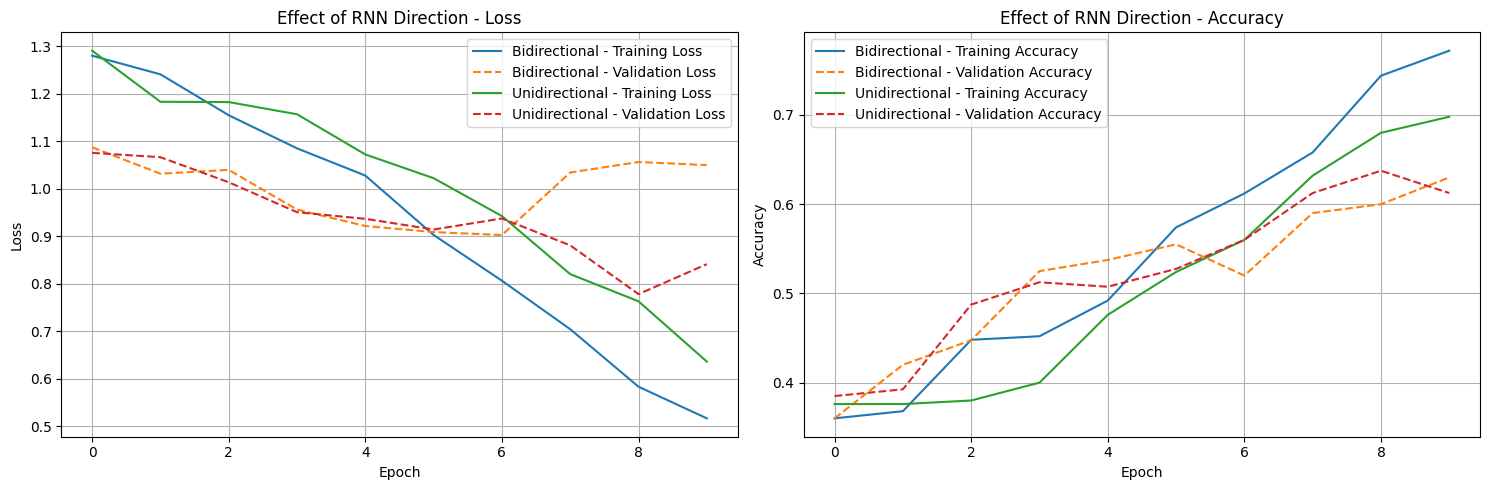

In [35]:
print("\n4. Experimenting with bidirectional vs unidirectional RNN...")
direction_variations = [True, False]
direction_labels = ['Bidirectional', 'Unidirectional']
direction_histories = []
direction_f1_scores = []

for bidirectional, label in zip(direction_variations, direction_labels):
    print(f"\nTraining {label} RNN model...")

    model = RNNModel(
        vocab_size=len(preprocessor.tokenizer.word_index) + 1,
        embedding_dim=128,
        max_length=100,
        num_classes=3
    )

    model.build_model(rnn_layers=2, rnn_units=64, bidirectional=bidirectional)
    history = model.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=32)
    f1_val, _ = model.evaluate(X_test, y_test)

    direction_histories.append(history)
    direction_f1_scores.append(f1_val)

    # Save model
    model.save_model(f'rnn_model_{label.lower()}.weights.h5')

# Plot results
plot_training_history(direction_histories, direction_labels,
                      'Effect of RNN Direction')

In [36]:
print("\nKesimpulan Percobaan Arah RNN:")
for label, f1 in zip(direction_labels, direction_f1_scores):
    print(f"{label}: F1-Score = {f1:.4f}")


Kesimpulan Percobaan Arah RNN:
Bidirectional: F1-Score = 0.4586
Unidirectional: F1-Score = 0.4934


### Train Model untuk Perbandingan Model

In [73]:
# Keras Model
best_model = RNNModel(
    vocab_size=len(preprocessor.tokenizer.word_index) + 1,
    embedding_dim=128,
    max_length=100,
    num_classes=3
)
best_model.build_model(rnn_layers=2, rnn_units=64, bidirectional=False)
best_model.train(X_train, y_train, X_val, y_val, epochs=5, batch_size=32)

# RNN Scratch
rnn_scratch = RNNFromScratch(
    vocab_size=len(preprocessor.tokenizer.word_index) + 1,
    embedding_dim=128,
    rnn_units=64,
    num_classes=3,
    max_length=100
)
rnn_scratch.load_keras_weights(best_model.model)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.3336 - loss: 1.3471 - val_accuracy: 0.3425 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.3877 - loss: 1.2081 - val_accuracy: 0.3625 - val_loss: 1.0982 - learning_rate: 0.0010
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.3981 - loss: 1.1974 - val_accuracy: 0.4125 - val_loss: 1.0731 - learning_rate: 0.0010
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.3676 - loss: 1.1447 - val_accuracy: 0.4275 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.4433 - loss: 1.0632 - val_accuracy: 0.4075 - val_loss: 1.0562 - learning_rate: 0.0010


### Percobaan 4: Hasil Percobaan Forward Propagation

In [74]:
# TEST 1: Bandingkan tanpa backprop
print("\n[TEST 1] Membandingkan Keras vs From-Scratch (Tanpa Backpropagation)...")
keras_pred = best_model.model.predict(X_test[:100])
keras_classes = np.argmax(keras_pred, axis=1)

scratch_pred = rnn_scratch.forward(X_test[:100], batch_size=32)
scratch_classes = np.argmax(scratch_pred, axis=1)

keras_f1 = f1_score(y_test[:100], keras_classes, average='macro')
scratch_f1 = f1_score(y_test[:100], scratch_classes, average='macro')

print(f"Keras Model F1-Score         : {keras_f1:.4f}")
print(f"From-Scratch Model F1-Score  : {scratch_f1:.4f}")
print(f"Difference                   : {abs(keras_f1 - scratch_f1):.4f}")



[TEST 1] Membandingkan Keras vs From-Scratch (Tanpa Backpropagation)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Keras Model F1-Score         : 0.3240
From-Scratch Model F1-Score  : 0.3032
Difference                   : 0.0208


### Percobaan 5: Hasil Percobaan Backward Propagation

In [84]:
print("\n[TEST 2] Melakukan 1x Backpropagation pada From-Scratch RNN...")

# Gunakan data yang sama untuk backward
y_true_batch = np.asarray(y_test[:100]).astype(int)

# Validasi bahwa semua label valid
assert np.all((y_true_batch >= 0) & (y_true_batch < rnn_scratch.num_classes)), \
    f"Label out of range: {np.unique(y_true_batch)} (max allowed = {rnn_scratch.num_classes - 1})"

# Lakukan backward pass (gunakan hasil prediksi sebelumnya)
rnn_scratch.backward(X_test[:100], y_true_batch, scratch_pred_before)

# Prediksi ulang setelah 1x update
scratch_pred_after = rnn_scratch.forward(X_test[:100], batch_size=32)
scratch_classes_after = np.argmax(scratch_pred_after, axis=1)
scratch_f1_after = f1_score(y_test[:100], scratch_classes_after, average='macro')

print(f"Scratch Model (After Backprop)   : {scratch_f1_after:.4f}")
print(f"Improvement                      : {scratch_f1_after - scratch_f1_before:.4f}")


[TEST 2] Melakukan 1x Backpropagation pada From-Scratch RNN...
Backward propagation applied to 100 samples across 4 batches.
Backward propagation with full BPTT applied.
Scratch Model (After Backprop)   : 0.3111
Improvement                      : 0.1821
